**Catégorisez automatiquement des questions**  
Ce projet a pour but de dévolopper un algorithme de machine learning pour assigner automatiquement des tags pertinents à des question possées par de nouveaux utilisateurs de la plateforme stackoverflow

### **1.&nbsp;Chargement des données**

In [1]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
2016_Building_Energy_Benchmarking.csv  olist_order_reviews_dataset.csv
clean-data.csv                         olist_orders_dataset.csv
fr.openfoodfacts.org.products.csv      olist_products_dataset.csv
house.csv                              olist-rfm.csv
logit_nlp_model.pkl                    olist_sellers_dataset.csv
multilabel_binarizer.pkl               product_category_name_translation.csv
olist_customers_dataset.csv            sea-clean-data.csv
olist-customers-segmentation.csv       stackoverflow-clean-data.csv
olist_geolocation_dataset.csv          stackoverflow.csv
olist_order_items_dataset.csv          tfidf_vectorizer.pkl
olist_order_payments_dataset.csv


In [2]:
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 2.5 MB/s eta 0:00:00
Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 28.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [5]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 4.8 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=a199460a3c6c995f082dd5840949e8312210958c79e1bdf95d1c02b7369e9351
  Stored in directory: /root/.cache/pip/wheels/41/01/29/deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel


In [6]:
# Import Python libraries
import os
import warnings
import time
import joblib
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
from IPython.core.display import display, HTML
from pandarallel import pandarallel

#RNN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras import backend as K

# Library for PEP8 standard
from nbpep8.nbpep8 import pep8


In [7]:
pandarallel.initialize(progress_bar=True,nb_workers=6)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
data = pd.read_csv('stackoverflow-clean-data.csv', sep=";", index_col=0,
                   converters={"Title": literal_eval,
                               "Body": literal_eval,
                               "Tags": literal_eval})

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Score,Tags
Id,,,,
21434218,"[masonry, lazyload]","[site, photographer, bootstrap, framework, mas...",13,"[javascript, jquery, css]"
18646874,"[force, compile, time, error, stdmove, copy]","[goingnative, talk, scott, meyers, guarantee, ...",23,"[c++, c++11]"
26458,"[ide, swing, application, development]","[ide, swing, application, line, visual, studio]",47,[java]
18647298,"[scipy, sparse, library, importerror, dll, loa...","[programming, bit, window, machine, library, i...",8,[python]
27492,"[c++, memory, management]","[college, object, example, code, rule, pointer...",8,[c++]


In [ ]:
data.tail()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Title,Body,Score,Tags
Id,,,,
46195559,[loop],"[component, parent, child, event, parent, resu...",14,"[javascript, reactjs]"
13263277,[difference],"[difference, example, case, result, behaviour,...",110,"[c++, c++11]"
46195465,"[c++, struct, class, base]","[type, trait, type, example, is_inherit, trait...",36,[c++]
28105661,"[substring, string]","[c#, string, sql, script, query, section, stri...",21,"[c#, regex, string]"
11117950,"[spacing, image, table]","[solution, programmer, html, code, html, email...",14,[html]


### **2.&nbsp;Preprocessing**

In [9]:
data["Full_doc"] = data["Title"] + data["Body"]
data["Full_doc"].head(3)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Id
21434218    [masonry, lazyload, site, photographer, bootst...
18646874    [force, compile, time, error, stdmove, copy, g...
26458       [ide, swing, application, development, ide, sw...
Name: Full_doc, dtype: object

In [10]:
X = data["Full_doc"]
y = data["Tags"]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **2.1.&nbsp;Tf-Idf**

In [11]:
from sklearn import set_config
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Initialize the "CountVectorizer" TFIDF for Full_doc
vectorizer = TfidfVectorizer(analyzer="word",
                             max_df=.5,
                             min_df=0.005,
                             tokenizer=None,
                             preprocessor=' '.join,
                             stop_words=None,
                             lowercase=False)

vectorizer.fit(X)
X_tfidf = vectorizer.transform(X)

print("Shape of X for Full_doc: {}".format(X_tfidf.shape))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape of X for Full_doc: (43332, 630)


In [13]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(y)
y_binarized = multilabel_binarizer.transform(y)

print("Shape of y: {}".format(y_binarized.shape))

Shape of y: (43332, 50)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (30332, 630)
X_test shape : (13000, 630)
y_train shape : (30332, 50)
y_test shape : (13000, 50)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **2.2.&nbsp;Word2Vec**

In [ ]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y_binarized,
                                                    test_size=0.3, random_state=8)
print("X_train_ shape : {}".format(X_train_.shape))
print("X_test_ shape : {}".format(X_test_.shape))
print("y_train_ shape : {}".format(y_train_.shape))
print("y_test_ shape : {}".format(y_test_.shape))

X_train_ shape : (30332,)
X_test_ shape : (13000,)
y_train_ shape : (30332, 50)
y_test_ shape : (13000, 50)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
w2v_model = gensim.models.Word2Vec(X_train_,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
w2v_model.wv.most_similar('file')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('txt', 0.7780229449272156),
 ('zip', 0.7706269025802612),
 ('directory', 0.7577799558639526),
 ('subdirectory', 0.7409401535987854),
 ('folder', 0.7192065119743347),
 ('pathname', 0.7027763724327087),
 ('filename', 0.6943109035491943),
 ('winzip', 0.6912567019462585),
 ('csv', 0.6869852542877197),
 ('saveas', 0.6797705888748169)]

In [ ]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-37e7fcca8068>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-16-37e7fcca8068>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtyp

###**2.3.&nbsp;Bert**

###**2.4.&nbsp;USE**

###**3.&nbsp;Modèles Non Supervisés**

###**3.1.&nbsp;Modèle LDA**

LDA, ou Latent Derelicht Analysis est un modèle probabiliste qui, pour obtenir des affectations de cluster, utilise deux valeurs de probabilité : *P(word/topics) et P(topics/documents)*. Ces valeurs sont calculées sur la base d'une attribution aléatoire initiale, puis le calcul est répété pour chaque mot dans chaque document, pour décider de leur attribution de sujet. Dans cette méthode itérative, ces probabilités sont calculées plusieurs fois, jusqu'à la convergence de l'algorithme.  
 Nous allons ici utiliser le bag of words et la librairie Gensim

In [ ]:
# Creation du sac de mots
id2word = corpora.Dictionary(X)
id2word.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
# Creation du Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 3), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 11), (22, 3), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)]]


Gensim crée un identifiant unique pour chaque mot du document puis mappe word_id et word_frequency. Exemple : (5,2) ci-dessus indique que word_id 5 apparaît 2 fois dans le document et ainsi de suite.
Les mots les plus fréquents ont ici aussi été filtrés grâce à la fonction filter_extremes réglée à 60% comme pour le Tfidf.

Pour voir quel mot correspond à un identifiant donné, il faut transmettre l'identifiant comme clé du dictionnaire. Exemple : id2word[5] :

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('answer', 3),
  ('bootstrap', 2),
  ('class', 1),
  ('code', 1),
  ('day', 1),
  ('effect', 2),
  ('error', 2),
  ('example', 3),
  ('fade', 1),
  ('fiddle', 1),
  ('forum', 1),
  ('framework', 1),
  ('function', 1),
  ('googling', 1),
  ('hair', 1),
  ('help', 1),
  ('image', 1),
  ('joy', 1),
  ('jquery', 1),
  ('line', 1),
  ('load', 1),
  ('masonry', 11),
  ('method', 3),
  ('must', 1),
  ('one', 1),
  ('pack', 1),
  ('page', 3),
  ('post', 1),
  ('problem', 1),
  ('site', 2),
  ('stackoverflow', 1),
  ('success', 1),
  ('typeerror', 1),
  ('update', 1),
  ('version', 1),
  ('zip', 1)]]

Nous allons maintenant entrainer le modèle LDA et afficher les deux metriques suivantes :  
* Perplexity :  C'est une mesure statistique de la capacité d'un model à predire 
* Coherence Score : C'est une mesure pour évaluer la qualité du topic appris

In [ ]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.857428506195882

Coherence Score:  0.43468042636169824


**Visualisation des résultats de LDA Gensim sur Full_doc avec 20 topics**

In [ ]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(full_lda_model, corpus, id2word)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.086089 -0.044764       1        1  9.426804
10    -0.095048 -0.024060       2        1  7.511589
0     -0.010780 -0.036082       3        1  6.328635
4     -0.004974  0.177527       4        1  6.098130
12    -0.101989 -0.039484       5        1  5.673445
14     0.015493 -0.025755       6        1  5.231932
19     0.111225 -0.021852       7        1  5.110431
13    -0.025572 -0.020032       8        1  5.062896
5     -0.075284 -0.043475       9        1  5.008163
7     -0.057073 -0.003802      10        1  4.816516
17     0.044946 -0.004312      11        1  4.772667
8      0.069829  0.032398      12        1  4.656215
18     0.082030 -0.026801      13        1  4.474110
2     -0.010045  0.096388      14        1  4.402185
15    -0.062167  0.002365      15        1  4.292516
6     -0.000400  0.005254      16        1  4.147515
16    -0.007015  0.060646      17        1  3.926562
9      0.001176 -0.000029      18        1  3.146283
3      0.031299 -0.033465      19        1  3.007359
1      0.008260 -0.050666      20        1  2.906048, topic_info=        Term          Freq         Total Category  logprob  loglift
120     file  18619.000000  18619.000000  Default  30.0000  30.0000
388    array   7695.000000   7695.000000  Default  29.0000  29.0000
248     data  11083.000000  11083.000000  Default  28.0000  28.0000
2      class  11287.000000  11287.000000  Default  27.0000  27.0000
266   string   8133.000000   8133.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
98    python    215.876268   6451.382350  Topic20  -5.2593   0.1410
76    thanks    207.123867   4446.506003  Topic20  -5.3007   0.4718
7    example    224.068454  11375.489477  Topic20  -5.2220  -0.3889
47      edit    211.942793   6514.470349  Topic20  -5.2777   0.1129
196        c    195.784546   5225.043816  Topic20  -5.3570   0.2542

[1700 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
441       1  0.033127     #
441       2  0.028108     #
441       3  0.043166     #
441       4  0.045174     #
441       5  0.081313     #
...     ...       ...   ...
2636     19  0.006043  zone
2636     20  0.688938  zone
6269      1  0.053356   zsh
6269      2  0.053356   zsh
6269     20  0.853695   zsh

[10355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 1, 5, 13, 15, 20, 14, 6, 8, 18, 9, 19, 3, 16, 7, 17, 10, 4, 2])

**Amélioration du modèle LDA**

Cependant, dans le précédent algoritmes LDA, nous avons fixé arbitrairement à 20 le paramètre num_topics qui représente le nombre de topics à créer. Pour optimiser notre modèle, un choix judicieux du nombre de topics s'impose. Nous allons pôur cela utiliser la modélisation HDP (Hierarchical Dirichlet Process), qui contrairement au LDA, déduit le nombre de topics à partir des données. Le nombre de topics par défaut est de 150. Afin de sélectionner le meilleur nombre de topics pour nos données, nous allons itérer sur la fourchette  de 150 topics et tester le score de cohérence pour chaque modèle :

In [ ]:
import time
time.clock = time.time

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(hdp_model.print_topics(num_topics=150))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.020*file + 0.017*code + 0.013*error + 0.011*problem + 0.009*application + 0.009*server + 0.009*app + 0.009*user + 0.009*time + 0.008*way'), (1, '0.022*code + 0.018*function + 0.016*type + 0.014*class + 0.011*way + 0.011*object + 0.011*value + 0.011*question + 0.011*time + 0.010*method'), (2, '0.014*code + 0.012*data + 0.011*table + 0.011*time + 0.011*problem + 0.010*way + 0.009*value + 0.009*query + 0.009*file + 0.008*question'), (3, '0.016*code + 0.013*file + 0.010*error + 0.009*problem + 0.008*way + 0.008*time + 0.007*user + 0.007*function + 0.007*class + 0.007*data'), (4, '0.016*code + 0.011*file + 0.011*app + 0.011*error + 0.009*problem + 0.008*way + 0.008*time + 0.007*android + 0.007*method + 0.006*class'), (5, '0.015*code + 0.012*file + 0.010*error + 0.009*function + 0.008*way + 0.007*problem + 0.007*time + 0.006*class + 0.006*method + 0.006*question'), (6, '0.014*code + 0.012*file + 0.010*error + 0.008*way + 0.007*function + 0.007*problem + 0.006*class + 0.006*time + 0.0

In [ ]:
coherence_test = []
for k in np.arange(1,150,10):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting LDA for K = 1


Fitting LDA for K = 11


Fitting LDA for K = 21


Fitting LDA for K = 31


Fitting LDA for K = 41


Fitting LDA for K = 51


Fitting LDA for K = 61


Fitting LDA for K = 71


Fitting LDA for K = 81


Fitting LDA for K = 91


Fitting LDA for K = 101


Fitting LDA for K = 111


Fitting LDA for K = 121


Fitting LDA for K = 131


Fitting LDA for K = 141


Affichons les scores des divers modèle :

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


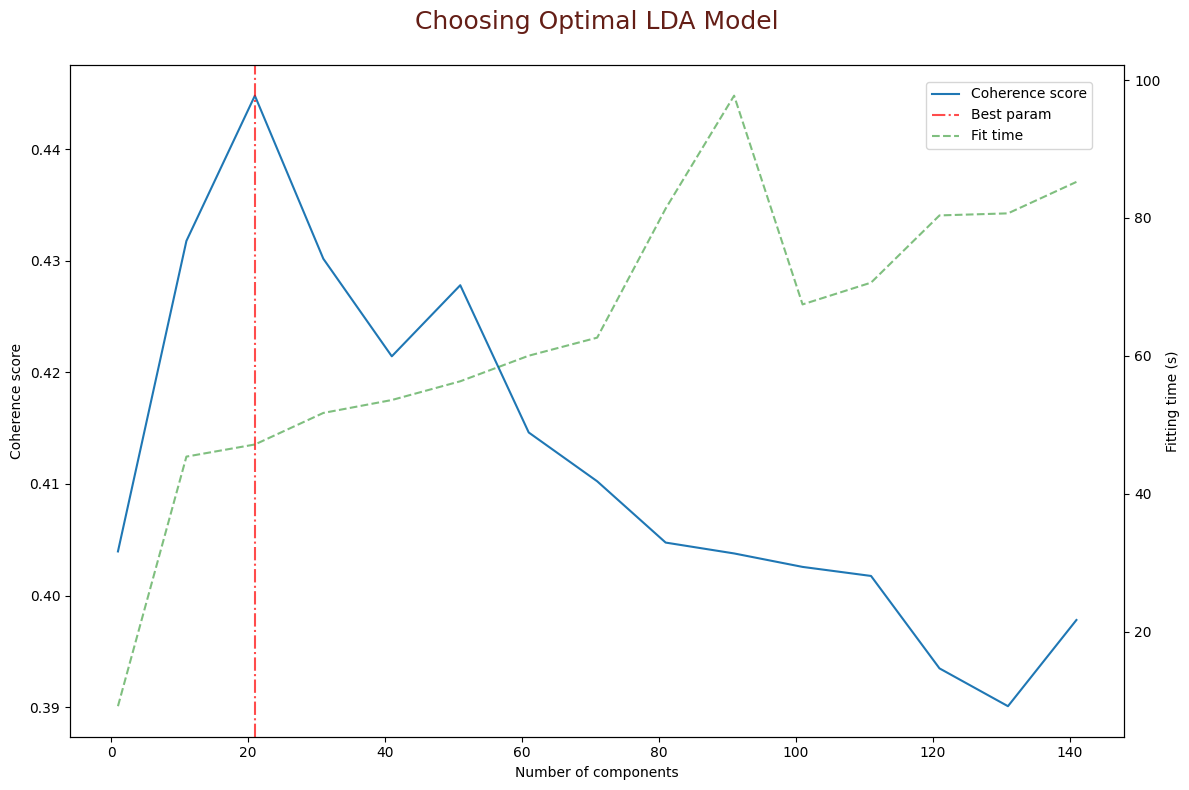

In [ ]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

Testons à présent le modèle avec le meilleur nombre théorique de topics pour l'afficher avec LDAvis :

In [ ]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=best_nb_topics,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
%matplotlib inline

display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

gensimvis.prepare(best_lda_model, corpus, id2word)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.079019 -0.041988       1        1  8.446062
10    -0.093856 -0.033693       2        1  6.717697
0     -0.010191 -0.029154       3        1  5.906540
12    -0.103649 -0.049796       4        1  5.811621
4     -0.023392  0.171555       5        1  5.768943
14     0.022803 -0.027467       6        1  5.228517
8      0.072256  0.046168       7        1  5.065166
7     -0.056624 -0.007096       8        1  4.943869
19     0.114054 -0.009359       9        1  4.902288
20     0.096256 -0.004062      10        1  4.856819
2     -0.031694  0.099397      11        1  4.748032
5     -0.084255 -0.046646      12        1  4.459434
13    -0.023894 -0.020208      13        1  4.353522
15    -0.067499 -0.000175      14        1  4.193998
17     0.042344 -0.003821      15        1  4.149481
6     -0.002138  0.023328      16        1  3.933620
16    -0.026707  0.043142      17        1  3.800265
18     0.058161 -0.012441      18        1  3.538529
3      0.032710 -0.026966      19        1  3.122724
9     -0.012041 -0.001606      20        1  3.062811
1      0.018336 -0.069111      21        1  2.990061, topic_info=        Term          Freq         Total Category  logprob  loglift
120     file  18204.000000  18204.000000  Default  30.0000  30.0000
248     data  11389.000000  11389.000000  Default  29.0000  29.0000
388    array   7621.000000   7621.000000  Default  28.0000  28.0000
2      class  11374.000000  11374.000000  Default  27.0000  27.0000
266   string   8053.000000   8053.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
196        c    239.466059   5216.618045  Topic21  -5.1841   0.4287
76    thanks    223.040138   4463.979140  Topic21  -5.2551   0.5134
7    example    256.866134  11336.487309  Topic21  -5.1139  -0.2774
266   string    238.479293   8053.642556  Topic21  -5.1882  -0.0097
51      idea    212.264094   4545.509888  Topic21  -5.3046   0.4458

[1771 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
441       1  0.034319     #
441       2  0.027039     #
441       3  0.081118     #
441       4  0.151837     #
441       5  0.015600     #
...     ...       ...   ...
2636     16  0.005776  zone
2636     17  0.005776  zone
2636     18  0.005776  zone
2636     20  0.005776  zone
2636     21  0.750931  zone

[11164 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 11, 1, 13, 5, 15, 9, 8, 20, 21, 3, 6, 14, 16, 18, 7, 17, 19, 4, 10, 2])

###**3.1'.&nbsp;Modèle LDA (Atester)**

In [ ]:
print(best_lda_model.print_topics(num_topics=-1))

[(0, '0.025*"memory" + 0.022*"time" + 0.016*"file" + 0.015*"problem" + 0.014*"system" + 0.012*"way" + 0.012*"process" + 0.011*"number" + 0.011*"code" + 0.009*"example"'), (1, '0.024*"time" + 0.018*"code" + 0.018*"function" + 0.015*"c#" + 0.015*"question" + 0.014*"key" + 0.013*"value" + 0.011*"process" + 0.011*"thread" + 0.011*"application"'), (2, '0.023*"code" + 0.019*"button" + 0.019*"page" + 0.015*"android" + 0.015*"jquery" + 0.015*"problem" + 0.012*"python" + 0.012*"way" + 0.012*"html" + 0.011*"javascript"'), (3, '0.028*"code" + 0.022*"class" + 0.016*"file" + 0.015*"method" + 0.014*"problem" + 0.014*"way" + 0.013*"constructor" + 0.013*"error" + 0.012*"thread" + 0.010*"function"'), (4, '0.029*"element" + 0.023*"text" + 0.015*"html" + 0.014*"table" + 0.013*"cs" + 0.013*"way" + 0.011*"image" + 0.010*"component" + 0.010*"code" + 0.010*"example"'), (5, '0.031*"project" + 0.023*"error" + 0.020*"studio" + 0.015*"user" + 0.014*"string" + 0.014*"visual" + 0.012*"code" + 0.012*"sql" + 0.011*"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Nous allons créer un dictionnaire avec pour clé le nom du topic et pour valeur la liste de tuple (mots, scores) qui composent le topic

In [ ]:
topics_words = {'Topic_' + str(i): [word for word, score in best_lda_model.show_topic(i, topn=100)] for i in range(0, best_lda_model.num_topics)}

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_words_score = {'Topic_' + str(i): [(word,score) for word, score in best_lda_model.show_topic(i, topn=100)] for i in range(0, best_lda_model.num_topics)}

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Nous allons ici créer la liste composée de tous les tags 

In [ ]:
def get_tags_list(column, df):
    tags_list = []
    for list_tag in df[column]:
      for word in list_tag:
        tags_list.append(word)
    return tags_list

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tags_list = get_tags_list("Tags",data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(tags_list)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


64372

In [ ]:
for i in tags_list:
  if i == 'c#':
    print(i)
    break

c#


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tags_list[:8]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['javascript', 'jquery', 'css', 'c++', 'c++11', 'java', 'python', 'c++']

In [ ]:
def keep_tag_only(topics_words, tags_list):
  topics_words_ = {}
  for k in topics_words:
    topics_words_[k] = [word for word in topics_words[k] if word in tags_list]
  return topics_words_


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_words_tags = keep_tag_only(topics_words, tags_list)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def keep_tag_only_score(topics_words, tags_list):
  topics_words_ = {}
  for k in topics_words:
    topics_words_[k] = [(word, score) for word, score in topics_words[k] if word in tags_list]
  return topics_words_

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_words_tags_score = keep_tag_only_score(topics_words_score, tags_list)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_words_tags_score['Topic_16']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('javascript', 0.012830111),
 ('php', 0.010216017),
 ('spring', 0.006037528),
 ('html', 0.0051201154),
 ('string', 0.0031329312),
 ('python', 0.0029465228),
 ('jquery', 0.002374722)]

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#test = 'I am trying to get list count in python and c# and also get list average'
test = 'I am trying to get list count in python and c# and also get list average'
test = test.lower()
test_list = []
''' test_list = nltk.tokenize.word_tokenize(test) '''
''' for x in test:
  test_list.extend(nltk.tokenize.word_tokenize(x)) '''
test_list = [test.split()]
stop_words = stopwords.words('english')
test_list = [word for word in test_list if word not in stop_words]
test_list

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['i',
  'am',
  'trying',
  'to',
  'get',
  'list',
  'count',
  'in',
  'python',
  'and',
  'c#',
  'and',
  'also',
  'get',
  'list',
  'average']]

In [ ]:
# Creation du sac de mots
test_dict = corpora.Dictionary(test_list)

# Term Document Frequency 
test_corpus = [test_dict.doc2bow(text) for text in test_list]  
test_corpus

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1)]]

In [ ]:
test_unseen = test_corpus[0]
test_unseen

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 2),
 (10, 1),
 (11, 1),
 (12, 1)]

In [ ]:
dist = best_lda_model.get_document_topics(test_unseen, minimum_probability=0)
dist

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.0028030465),
 (1, 0.0028030465),
 (2, 0.0028030465),
 (3, 0.0028030465),
 (4, 0.0028030465),
 (5, 0.0028030465),
 (6, 0.0028030465),
 (7, 0.0028030465),
 (8, 0.6741521),
 (9, 0.0028030465),
 (10, 0.0028030465),
 (11, 0.0028030465),
 (12, 0.0028030465),
 (13, 0.0028030465),
 (14, 0.27259007),
 (15, 0.0028030465),
 (16, 0.0028030465),
 (17, 0.0028030465),
 (18, 0.0028030465),
 (19, 0.0028030465),
 (20, 0.0028030465)]

In [ ]:
''' prob = best_lda_model[test_unseen]
prob '''

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' prob = best_lda_model[test_unseen]\nprob '

In [ ]:
from operator import itemgetter
def get_topic(unseen, lda_model):
  result = lda_model.get_document_topics(unseen,minimum_probability=0)
  #result = lda_model[unseen]
  topic = max(result,key=itemgetter(1))[0]
  return 'Topic_'+str(topic)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic = get_topic(test_unseen,best_lda_model)
topic

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Topic_8'

In [ ]:
tag = topics_words_tags[topic]
tag

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['jquery',
 'php',
 'algorithm',
 'performance',
 'javascript',
 'python',
 'c',
 'c++',
 'string',
 'java',
 'r',
 'mysql']

In [ ]:
''' tag_score = topics_words_tags_score[topic]
tag_score '''

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' tag_score = topics_words_tags_score[topic]\ntag_score '

In [ ]:
''' def get_tags(unseen, lda_model):
  result = lda_model[unseen]
  result = [('Topic_'+str(topic),score) for topic,score in result]
  topics_words_tags_score_ = {}
  for topic, score in result:
    topics_words_tags_score_[topic] = sorted([(item[0],score*item[1]) for item in topics_words_tags_score[topic]], key=lambda x:x[1],reverse=True)
  
  return topics_words_tags_score_ '''

In [ ]:
def get_best_tags(unseen_num, unseen_str, lda_model):
  #result = lda_model[unseen]
  result = lda_model.get_document_topics(unseen_num,minimum_probability=0)
  #result = [('Topic_'+str(topic),score) for topic,score in result]
  result = [('Topic_'+str(stuff[0]),(stuff[1])) for stuff in result]
  tags_score = []
  best_tags_score = []
  for stuff in result:
    tags_score.extend([(item[0],stuff[1]*item[1]) for item in topics_words_tags_score[stuff[0]]])
  best_tags_score = sorted(tags_score,key=lambda x:x[1],reverse=True)
  best_tags_score = dict([(item[0], item[1]) for item in best_tags_score if item[0] in unseen_str[0]]).items()
  return best_tags_score

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
best_tags = get_best_tags(test_unseen,test_list,best_lda_model)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
best_tags

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_items([('python', 5.331459e-06), ('c#', 5.9454937e-06)])

In [ ]:
test_list

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['i',
  'am',
  'trying',
  'to',
  'get',
  'list',
  'count',
  'in',
  'python,',
  'and',
  'also',
  'get',
  'list',
  'average']]

In [ ]:
xvf

{'Topic_0': [('string', 2.1526963e-05),
  ('python', 1.8249395e-05),
  ('linux', 1.5751712e-05),
  ('performance', 1.35739965e-05),
  ('algorithm', 1.0710199e-05),
  ('c', 1.0263321e-05),
  ('c++', 7.3327747e-06),
  ('r', 7.2831217e-06),
  ('java', 6.9793964e-06),
  ('regex', 6.442562e-06)],
 'Topic_1': [('c#', 4.8565955e-05),
  ('java', 2.3462115e-05),
  ('c', 1.7805824e-05),
  ('string', 1.7732462e-05),
  ('python', 1.425465e-05),
  ('php', 1.3350114e-05),
  ('ruby', 9.735833e-06),
  ('javascript', 8.866146e-06),
  ('android', 6.3292796e-06)],
 'Topic_2': [('android', 4.7863537e-05),
  ('jquery', 4.673942e-05),
  ('python', 3.8414782e-05),
  ('html', 3.663735e-05),
  ('javascript', 3.6286292e-05),
  ('php', 8.9885825e-06),
  ('json', 6.572365e-06),
  ('string', 6.207952e-06)],
 'Topic_3': [('c++', 3.0642284e-05),
  ('c', 1.9546567e-05),
  ('java', 1.7686607e-05),
  ('string', 1.2814496e-05),
  ('android', 9.993716e-06),
  ('algorithm', 7.315188e-06),
  ('python', 6.0421294e-06)],
 'T

On remarque ici que la modélisation non supervisée avec LDA n'est pas adaptée. En effet, le meilleur nombre de topics se situerait à 21, mais l'algorithme ne parvient pas a établir de groupes bien distincts. Un certain nombre de topics sont très regroupés et donc représentés par les mêmes termes.

###**3.2.&nbsp;Modèle NMF**

Nous allons nous baser sur les résultats de la LDA pour déterminer le nombre de topics, nous prendrons **best_nb_topics**, nous utiliserons les matrices Tfidf créées lors du preprocessing.

In [ ]:
def plot_top_words(model, feature_names, 
                   n_top_words, nb_topic_plot, title):
    rows = int(nb_topic_plot/5)
    fig, axes = plt.subplots(rows, 5, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

--------------------------------------------------
Start NMF fitting on Full_doc ...
--------------------------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


End of training :
Execution time : 22.67s
--------------------------------------------------


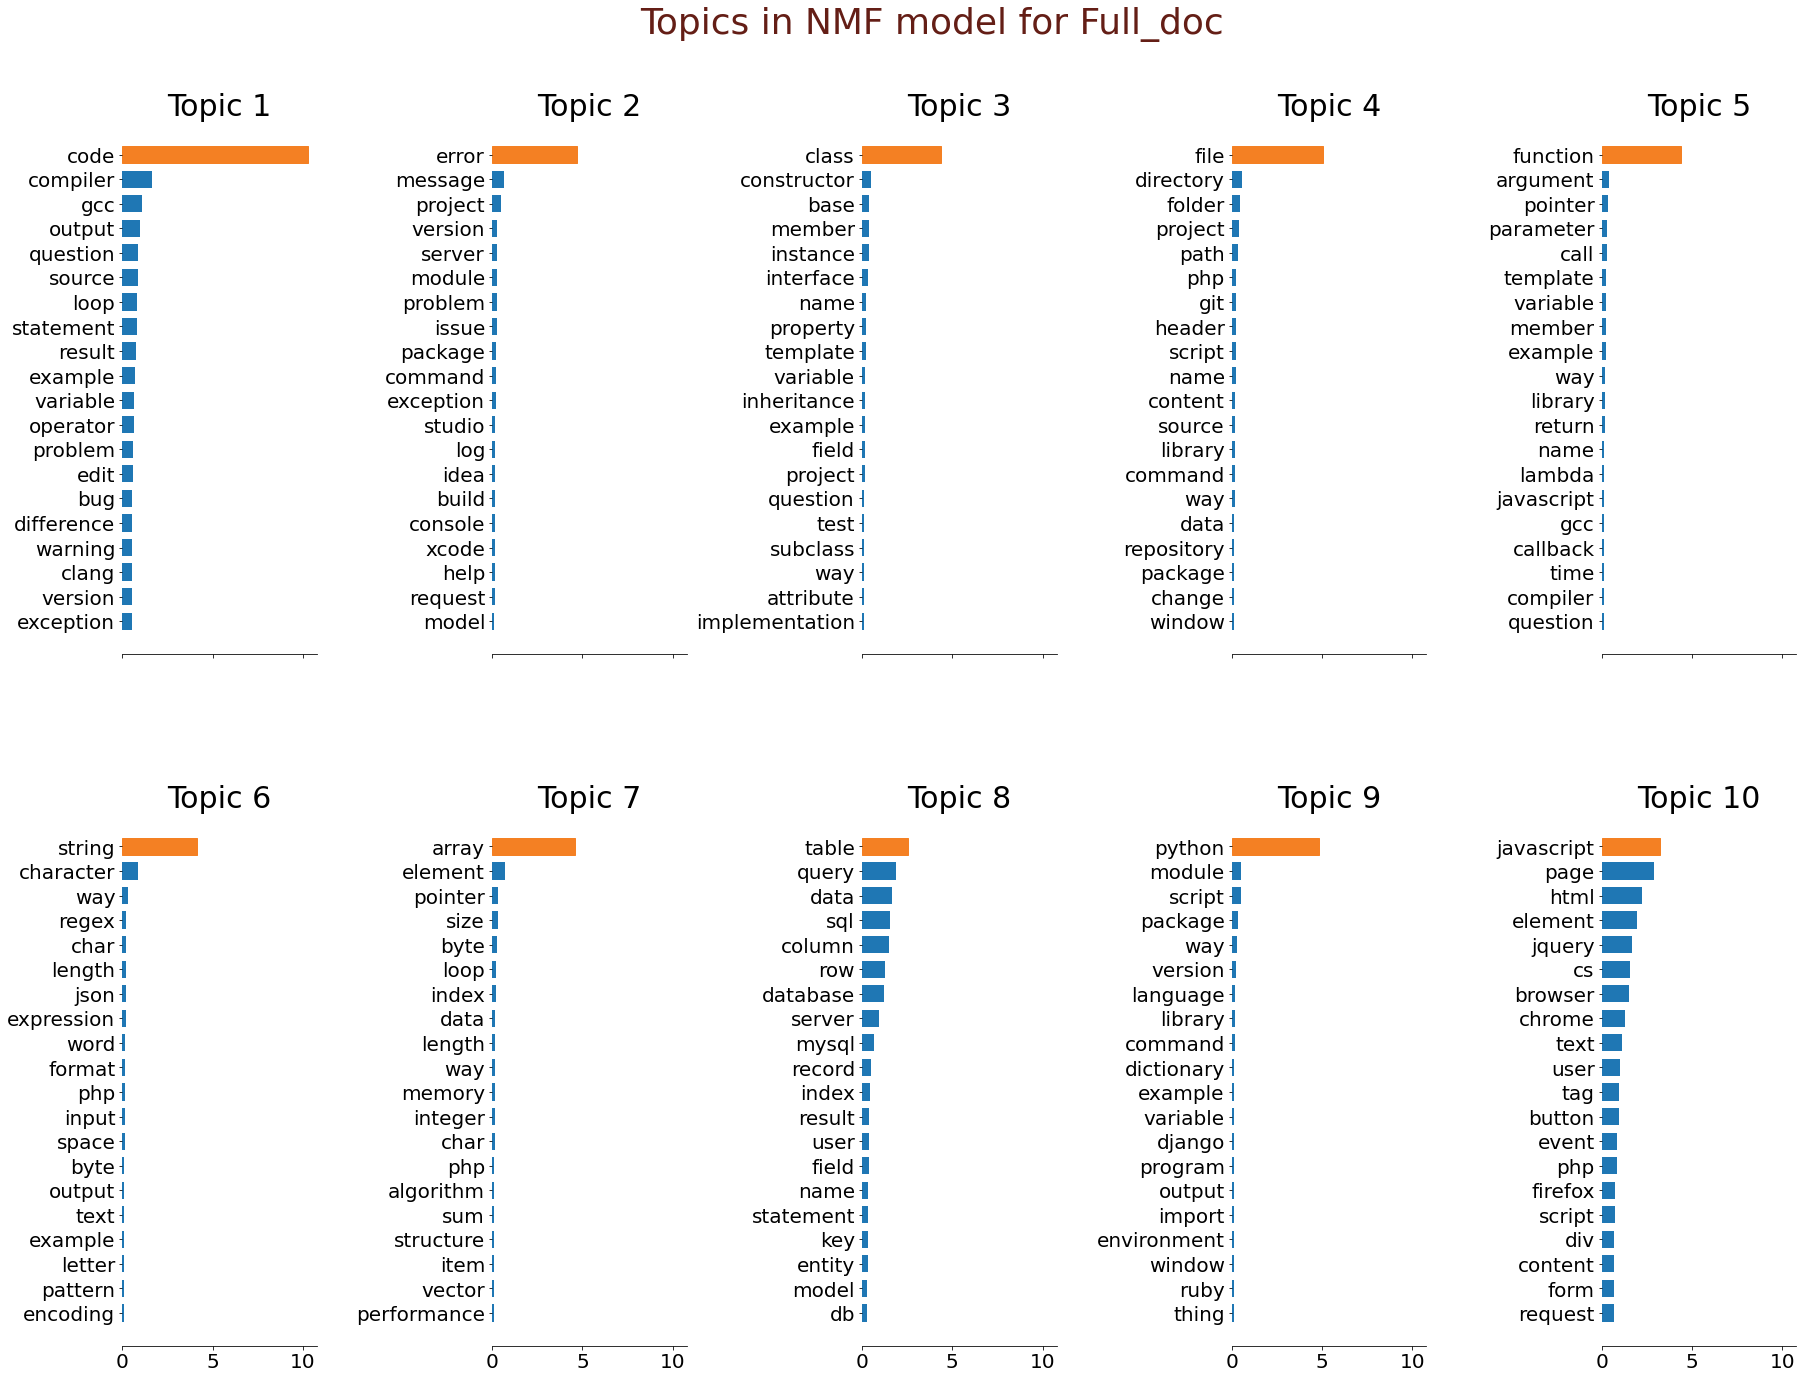

In [ ]:
# Define number of topics to test
n_topics = best_nb_topics

print("-"*50)
print("Start NMF fitting on Full_doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)

# Plot the 12 first topics
ff_feature_names = vectorizer.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 10,
               'Topics in NMF model for Full_doc')

La modélisation avec NMF nous apporte des catégories aussi lisibles que celles de l'algorithme LDA. 1 mot est toujours beaucoup plus représentaif de cette catégorie mais les regroupements sont globalement cohérents.

En revanche, les topics générés restent très généraux et ne permettent pas une catégorisation cohérente pour notre problème d'auto-tagging. Nous allons donc tester des modèles supervisés.

###**4.&nbsp;Modèles Supervisés**

**Calcul avec Tfidf**

In [15]:
def metrics_score(model, df, y_true, y_pred):
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###**4.1.&nbsp;RandomForest**

In [16]:
# Initialize RandomForest with OneVsRest
''' param_rfc = {'estimator__max_features' : ['sqrt', 'log2'],
             'estimator__max_depth': [5, 15, 25],
             'estimator__min_samples_split': [2, 5, 10],
             'estimator__bootstrap' : [True, False],
             'estimator__min_samples_leaf': [1,2,5],
             'estimator__class_weight': ["balanced"]} '''
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train[0:7000], y_train[0:7000])

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [17]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c++',), ('c', 'c++'), ('javascript', 'php'), ('c', 'ruby', 'ruby-on-rails'), ('c++', 'c++11')]
True: [('c++',), ('python',), ('php',), ('ruby-on-rails',), ('c++', 'c++11')]


In [ ]:
''' def metrics_score(model, df, y_true, y_pred):
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])
        
    scores = []
    scores.append(metrics.accuracy_score(y_true, 
                                         y_pred))
    scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true, 
                                       y_pred, 
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true, 
                                          y_pred, 
                                          average='weighted'))
    temp_df[model] = scores
    
    return temp_df '''

In [21]:
df_metrics_compare = metrics_score("RandomForest", 
                                   df=None,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,RandomForest
Accuracy,0.230154
F1,0.576130
Jaccard,0.442339
Recall,0.692878
Precision,0.540434


###**4.2.&nbsp;LogisticRegression**

In [22]:
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [23]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
logit_cv_results[logit_cv_results["params"]==logit_best_params]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__dual,param_estimator__penalty,param_estimator__solver,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,27.893208,1.805348,0.095808,0.03526,10,False,l1,liblinear,"{'estimator__C': 10, 'estimator__dual': False,...",0.570622,...,0.567205,0.006063,1,0.645912,0.647696,0.648507,0.648422,0.648732,0.647854,0.001031


In [25]:
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), (), ('php',), (), ('c++',)]
True: [('c++',), ('python',), ('php',), ('ruby-on-rails',), ('c++', 'c++11')]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
df_metrics_compare = metrics_score("Logit", 
                                   df=df_metrics_compare, 
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,RandomForest,Logit
Accuracy,0.230154,0.330154
F1,0.576130,0.606463
Jaccard,0.442339,0.419245
Recall,0.692878,0.476997
Precision,0.540434,0.725265


###**4.3.&nbsp;NeuronNetwork**

In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

''' def jaccard_m(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth '''

def jaccard_m(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection) / (sum_ - intersection)
    return (1 - jac)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
def build_nn(input_dim, hidden_neurons, output_dim):
    """
    Construct a Keras model which will be used to 
    fit/predict in SKlearn pipeline.
    """
    # Create brain
    model = Sequential()
    model.add(layers.Dense(hidden_neurons,
                           input_dim=input_dim,
                           activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(hidden_neurons,
                           input_dim=input_dim,
                           activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(output_dim,
                           activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', recall_m, precision_m, f1_m, jaccard_m])
    model.summary()
    
    return model
    

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
clear_session()

model_params = {
    'input_dim': X_train.shape[1],
    'hidden_neurons': 150,
    'output_dim': y_train.shape[1]}

keras_model = build_nn(**model_params)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               94650     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 150)               22650     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                7550      
                                                                 
Total params: 124,850
Trainable params: 124,850
Non-trainable params: 0
_________________________________________________________________


In [30]:
# evaluate the model
scores = keras_model.evaluate(X_test.toarray(), y_test)
df_metrics_compare["Keras NN"] = [scores[i] for i in [1,4,5,2,3]]
df_metrics_compare

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


407/407 [==============================] - 3s 3ms/step - loss: 0.6942 - accuracy: 0.0078 - recall_m: 0.5522 - precision_m: 0.0311 - f1_m: 0.0589 - jaccard_m: 0.9711


,RandomForest,Logit,Keras NN
Accuracy,0.230154,0.330154,0.007769
F1,0.576130,0.606463,0.058903
Jaccard,0.442339,0.419245,0.971132
Recall,0.692878,0.476997,0.552166
Precision,0.540434,0.725265,0.031122


###**5.&nbsp;Choix de modèle et teste API**

Le modèle de logit est celui qui performe le mieux en se basant sur le compromis fait sur les metruques F1,Precision,Recall et Jaccard  

Nous allons exporter le modèle entrainé ainsi que les preprocessing Tfidf et multilaber_binarizer entrainés pour les intégrer à cette API.

In [ ]:
# Export fitted model and Preprocessor
joblib.dump(multi_logit_cv,'logit_nlp_model.pkl')


['logit_nlp_model.pkl']

In [ ]:
joblib.dump(vectorizer,'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [ ]:
joblib.dump(multilabel_binarizer,'multilabel_binarizer.pkl')

['multilabel_binarizer.pkl']

In [3]:
import requests

headers = {'Content-type': 'application/json'}
response = requests.get('https://stackoverflow-tag-api.herokuapp.com/autotag/Test%20with%20Python%20question%20or%20Javascript%20integration%20problem',
                        headers=headers)
print("-"*50)
print("API test response :")
print("-"*50)
print(response.json())

--------------------------------------------------
API test response :
--------------------------------------------------
{'Predicted_Tags': [['javascript', 'python']], 'Predicted_Tags_Probabilities': {'python': 0.9998155608522982, 'javascript': 0.9841214287834249}}
